In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

nba_2016_2017_100.csv
nba_2017_att_val.csv
nba_2017_att_val_elo.csv
nba_2017_att_val_elo_with_cluster.csv
nba_2017_attendance.csv
nba_2017_br.csv
nba_2017_elo.csv
nba_2017_endorsements.csv
nba_2017_nba_players_with_salary.csv
nba_2017_pie.csv
nba_2017_player_wikipedia.csv
nba_2017_players_stats_combined.csv
nba_2017_players_with_salary_wiki_twitter.csv
nba_2017_real_plus_minus.csv
nba_2017_salary.csv
nba_2017_team_valuations.csv
nba_2017_twitter_players.csv



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import minmax_scale
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**Preparing dataset**

In [3]:
attendance_valuation_elo_df = pd.read_csv("../input/nba_2017_att_val_elo.csv")
attendance_valuation_elo_df.head()

,Unnamed: 0,TEAM,GMS,TOTAL,AVG,PCT,VALUE_MILLIONS,ELO,CONF
0,0,Chicago Bulls,41,888882,21680,103.6,2500.0,1519,East
1,1,Dallas Mavericks,41,811366,19789,103.1,1450.0,1420,West
2,2,Sacramento Kings,41,721928,17608,100.6,1075.0,1393,West
3,3,Miami Heat,41,805400,19643,100.2,1350.0,1569,East
4,4,Toronto Raptors,41,813050,19830,100.2,1125.0,1600,East


In [4]:
salary_df = pd.read_csv("../input/nba_2017_salary.csv")
salary_df.rename(columns={'NAME': 'PLAYER'}, inplace=True)
salary_df = salary_df.merge(attendance_valuation_elo_df, how = 'left', on = 'TEAM')
salary_df = salary_df.drop(['Unnamed: 0',], axis = 1)
salary_df.head()

,PLAYER,POSITION,TEAM,SALARY,GMS,TOTAL,AVG,PCT,VALUE_MILLIONS,ELO,CONF
0,LeBron James,SF,Cleveland Cavaliers,30963450.0,41.0,843042.0,20562.0,100.0,1200.0,1545.0,East
1,Mike Conley,PG,Memphis Grizzlies,26540100.0,41.0,677314.0,16519.0,91.2,790.0,1482.0,West
2,Al Horford,C,Boston Celtics,26540100.0,41.0,760690.0,18553.0,99.6,2200.0,1587.0,East
3,Dirk Nowitzki,PF,Dallas Mavericks,25000000.0,41.0,811366.0,19789.0,103.1,1450.0,1420.0,West
4,Carmelo Anthony,SF,New York Knicks,24559380.0,41.0,810741.0,19774.0,99.8,3300.0,1374.0,East


In [5]:
pie_df = pd.read_csv("../input/nba_2017_pie.csv")
pie_df = pie_df[['PLAYER','AGE','GP','W','L']]
pie_df['winning_rate'] = pie_df['W'] / pie_df['GP']
pie_df = pie_df[['PLAYER','AGE','winning_rate']]
pie_df.head()

,PLAYER,AGE,winning_rate
0,Russell Westbrook,28,0.567901
1,Boban Marjanovic,28,0.457143
2,Demetrius Jackson,22,0.200000
3,Anthony Davis,24,0.413333
4,James Harden,27,0.666667


In [6]:
nba_2017_br = pd.read_csv("../input/nba_2017_br.csv")
nba_2017_br = nba_2017_br[['Player','Pos','MP']]
nba_2017_br = nba_2017_br.rename(columns = {'Player':'PLAYER'})
nba_2017_br = nba_2017_br.merge(pie_df, how = 'inner', on = 'PLAYER')
nba_2017_br = nba_2017_br.merge(salary_df, how = 'inner', on = 'PLAYER')
nba_2017_br.head()

,PLAYER,Pos,MP,AGE,winning_rate,POSITION,TEAM,SALARY,GMS,TOTAL,AVG,PCT,VALUE_MILLIONS,ELO,CONF
0,Russell Westbrook,PG,34.6,28,0.567901,PG,Oklahoma City Thunder,26500000.0,41.0,746323.0,18203.0,100.0,1025.0,1543.0,West
1,James Harden,PG,36.4,27,0.666667,PG,Houston Rockets,26500000.0,41.0,695903.0,16973.0,94.1,1650.0,1602.0,West
2,Isaiah Thomas,PG,33.8,28,0.671053,PG,Boston Celtics,6587132.0,41.0,760690.0,18553.0,99.6,2200.0,1587.0,East
3,Anthony Davis,C,36.1,24,0.413333,PF,New Orleans Pelicans,22116750.0,41.0,663099.0,16173.0,94.1,750.0,1482.0,West
4,DeMarcus Cousins,C,34.2,26,0.416667,C,Sacramento Kings,16957900.0,41.0,721928.0,17608.0,100.6,1075.0,1393.0,West


In [7]:
nba_2017_twitter_players = pd.read_csv("../input/nba_2017_twitter_players.csv")
nba_2017_br = nba_2017_br.merge(nba_2017_twitter_players, how = 'inner', on = 'PLAYER')
nba_2017_br.head()

,PLAYER,Pos,MP,AGE,winning_rate,POSITION,TEAM,SALARY,GMS,TOTAL,AVG,PCT,VALUE_MILLIONS,ELO,CONF,TWITTER_FAVORITE_COUNT,TWITTER_RETWEET_COUNT
0,Russell Westbrook,PG,34.6,28,0.567901,PG,Oklahoma City Thunder,26500000.0,41.0,746323.0,18203.0,100.0,1025.0,1543.0,West,2130.5,559.0
1,James Harden,PG,36.4,27,0.666667,PG,Houston Rockets,26500000.0,41.0,695903.0,16973.0,94.1,1650.0,1602.0,West,969.0,321.5
2,Isaiah Thomas,PG,33.8,28,0.671053,PG,Boston Celtics,6587132.0,41.0,760690.0,18553.0,99.6,2200.0,1587.0,East,467.5,155.5
3,Anthony Davis,C,36.1,24,0.413333,PF,New Orleans Pelicans,22116750.0,41.0,663099.0,16173.0,94.1,750.0,1482.0,West,368.0,104.0
4,DeMarcus Cousins,C,34.2,26,0.416667,C,Sacramento Kings,16957900.0,41.0,721928.0,17608.0,100.6,1075.0,1393.0,West,102.0,91.5


**Correlation heatmap**

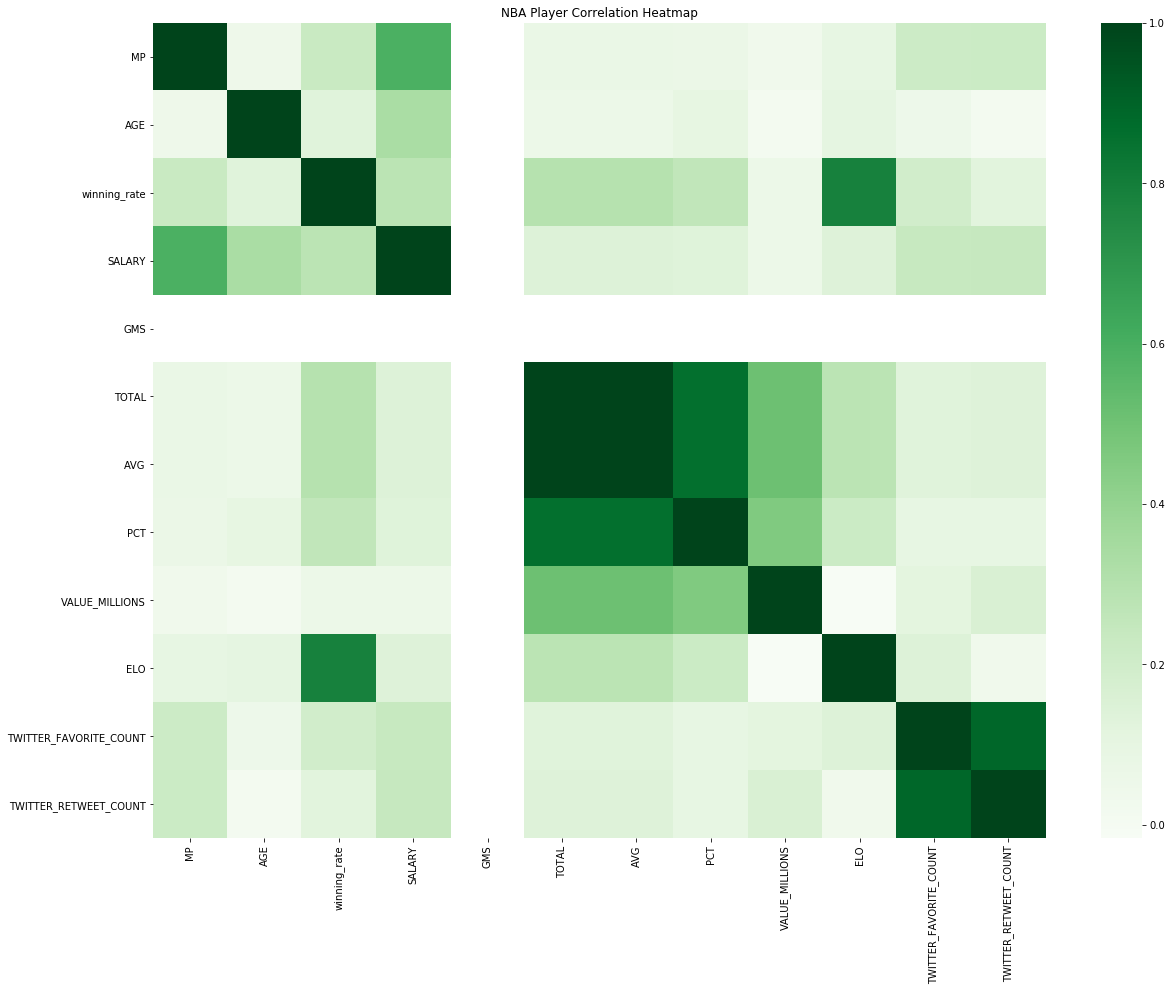

In [8]:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("NBA Player Correlation Heatmap")
corr = nba_2017_br.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,cmap="Greens")

**Prepossing the data**

In [9]:
#Remove missing values
nba_2017_br = nba_2017_br.dropna()

cat_cols = ['PLAYER','Pos','TEAM','CONF','POSITION']

# Rescale numetic columns(Expecting target column i.e. winning_rate)
num_cols = list(nba_2017_br.drop(cat_cols,axis = 1).columns.drop('winning_rate'))
for col in num_cols:
    nba_2017_br[col + 'scaled'] = minmax_scale(nba_2017_br[col])
    nba_2017_br = nba_2017_br.drop(col,axis = 1)
    
    
#Create dummy variables
for col in cat_cols:
    dummies = pd.get_dummies(nba_2017_br[col], prefix = col)
    nba_2017_br = pd.concat([nba_2017_br,dummies], axis = 1)
    nba_2017_br = nba_2017_br.drop(col,axis = 1)

nba_2017_br.head()

,winning_rate,MPscaled,AGEscaled,SALARYscaled,GMSscaled,TOTALscaled,AVGscaled,PCTscaled,VALUE_MILLIONSscaled,ELOscaled,...,CONF_West,POSITION_ C,POSITION_ F,POSITION_ G,POSITION_ PF,POSITION_ PG,POSITION_ SF,POSITION_ SG,POSITION_PG,POSITION_SF
0,0.567901,0.909091,0.428571,0.855579,0.0,0.496786,0.496816,0.884615,0.107843,0.474537,...,1,0,0,0,0,0,0,0,1,0
1,0.666667,0.960227,0.380952,0.855579,0.0,0.318810,0.318813,0.695513,0.352941,0.611111,...,1,0,0,0,0,0,0,0,1,0
2,0.671053,0.886364,0.428571,0.211270,0.0,0.547500,0.547467,0.871795,0.568627,0.576389,...,0,0,0,0,0,1,0,0,0,0
3,0.413333,0.951705,0.238095,0.713753,0.0,0.203017,0.203039,0.695513,0.000000,0.333333,...,1,0,0,0,1,0,0,0,0,0
4,0.416667,0.897727,0.333333,0.546831,0.0,0.410675,0.410709,0.903846,0.127451,0.127315,...,1,1,0,0,0,0,0,0,0,0


**Assign dependent and independent variables**

In [10]:
all_X = nba_2017_br.drop('winning_rate', axis = 1)
y = nba_2017_br['winning_rate']

**Apply LinearRegression Model**

In [11]:
lr = LinearRegression()
results = lr.fit(all_X,y)
predictions = lr.predict(nba_2017_br[all_X.columns])
mse = mean_squared_error(predictions, nba_2017_br['winning_rate'])
mse

7.3408588541492911e-32

In [14]:
model = sm.OLS(y, all_X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              R-squared   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Thu, 18 Jan 2018   Prob (F-statistic):                nan
Time:                        09:08:59   Log-Likelihood:                 7254.2
No. Observations:                 245   AIC:                        -1.402e+04
Df Residuals:                       0   BIC:                        -1.316e+04
Df Model:                         244                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
MPscaled                            0.0967        inf          0        nan         nan         nan
AGEscaled                           0.0131        inf          0        nan         nan         nan
SALARYscaled                    -2.842e-13        inf         -0        nan         nan         nan
GMSscaled                        1.356e-14        inf          0        nan         nan         nan
TOTALscaled                         0.0256        inf          0        nan         nan         nan
AVGscaled                           0.0257        inf          0        nan         nan         nan
PCTscaled                           0.0700        inf          0        nan         nan         nan
VALUE_MILLIONSscaled                0.0071        inf          0        nan         nan         nan
ELOscaled                           0.3218        inf          0        nan         nan         nan
TWITTER_FAVORITE_COUNTscaled        0.0208        inf          0        nan         nan         nan
TWITTER_RETWEET_COUNTscaled         0.0297        inf          0        nan         nan         nan
PLAYER_Aaron Brooks                 0.0428        inf          0        nan         nan         nan
PLAYER_Aaron Gordon                 0.0026        inf          0        nan         nan         nan
PLAYER_Adreian Payne               -0.0329        inf         -0        nan         nan         nan
PLAYER_Al Horford                   0.0378        inf          0        nan         nan         nan
PLAYER_Al-Farouq Aminu              0.0249        inf          0        nan         nan         nan
PLAYER_Alec Burks                   0.0155        inf          0        nan         nan         nan
PLAYER_Alex Len                     0.0262        inf          0        nan         nan         nan
PLAYER_Allen Crabbe                -0.0309        inf         -0        nan         nan         nan
PLAYER_Amir Johnson                 0.0211        inf          0        nan         nan         nan
PLAYER_Andre Iguodala               0.0486        inf          0        nan         nan         nan
PLAYER_Andre Roberson              -0.0053        inf         -0        nan         nan         nan
PLAYER_Andrew Bogut                -0.2237        inf         -0        nan         nan         nan
PLAYER_Andrew Harrison              0.0134        inf          0        nan         nan         nan
PLAYER_Andrew Nicholson            -0.0186        inf         -0        nan         nan         nan
PLAYER_Andrew Wiggins              -0.0369        inf         -0        nan         nan         nan
PLAYER_Anthony Bennett             -0.1470        inf         -0        nan         nan         nan
PLAYER_Anthony Brown               -0.0366        inf         -0        nan        

Mean_sqaured_error is slim to none and R-squared = 1.000 prove the linear regression model is a fit in this case.